In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


**Import packages**

In [2]:
#data analysis libraries 
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#ignore warnings
import warnings
warnings.filterwarnings('ignore')


**Preprocessing**

In [3]:
#define directory of the project
path = "/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN" 

In [4]:
#read movie , rating and tag csv files 
movie = pd.read_csv(path + "/datasets/ml-latest-small/movies.csv",sep=',',index_col=None,)
ratings = pd.read_csv(path + "/datasets/ml-latest-small/ratings.csv")
tags = pd.read_csv(path + "/datasets/ml-latest-small/tags.csv")

In [5]:
#prints out the information of the dataframe
def getinfo(df):
  print("Shape of dataframe : ",df.shape)
  print(" columns : ", df.columns,end="\n\n")
  print(df.info())
  print(df.head(3))

In [6]:
getinfo(movie)

Shape of dataframe :  (9742, 3)
 columns :  Index(['movieId', 'title', 'genres'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
   movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance

[3 rows x 3 columns]


In [7]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
# Seperate the Geners Column on '|' and Encoding them with One-Hot-Encoding Method.
genres=[]
for i in range(len(movie.genres)):
    for x in movie.genres[i].split('|'):
        if x not in genres:
            genres.append(x)  

# len(genres)
for x in genres:
    movie[x] = 0
for i in range(len(movie.genres)):
    for x in movie.genres[i].split('|'):
        movie[x][i]=1

movie.drop(columns='genres',inplace=True)
movie.sort_index(inplace=True)

movie.head()

,movieId,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
#checking ratings dataframe
getinfo(ratings)

Shape of dataframe :  (100836, 4)
 columns :  Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224


In [10]:
print(movie.columns)

Index(['movieId', 'title', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western',
       'Film-Noir', '(no genres listed)'],
      dtype='object')


In [11]:
#we need to combine the movie and rating dataframe
movie = movie.merge(ratings, how='inner')
movie.head()

,movieId,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),userId,rating,timestamp
0,1,Toy Story (1995),1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0,964982703
1,1,Toy Story (1995),1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,4.0,847434962
2,1,Toy Story (1995),1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,4.5,1106635946
3,1,Toy Story (1995),1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,2.5,1510577970
4,1,Toy Story (1995),1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,4.5,1305696483


In [12]:
#plot frequency of genre
def frequencyPlot(df,startat,endsat):
  x={}
  for i in df.columns[startat:endsat]:
    x[i]=df[i].value_counts()[1]
    print("{}      \t{}".format(i,x[i]))
  plt.figure(figsize=(10,12))
  plt.bar(height=x.values(),x=x.keys())
  plt.show()

Animation      	6988
Children      	9208
Comedy      	39053
Fantasy      	11834
Romance      	18124
Drama      	41928
Action      	30635
Crime      	16681
Thriller      	26452
Horror      	7291
Mystery      	7674
Sci-Fi      	17243
War      	4859
Musical      	4138
Documentary      	1219
IMAX      	4145
Western      	1930
Film-Noir      	870
(no genres listed)      	47
userId      	232


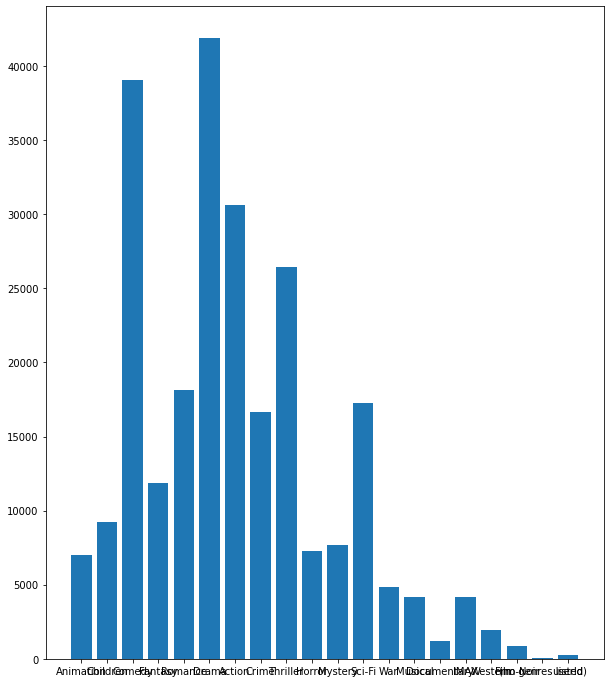

In [13]:
frequencyPlot(movie,3,23)

In [14]:
#sort values on userId
movie.sort_values(by=['userId'], ascending=True)

,movieId,title,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),userId,rating,timestamp
0,1,Toy Story (1995),1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0,964982703
35548,1777,"Wedding Singer, The (1998)",0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0,964981230
35249,1732,"Big Lebowski, The (1998)",0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,5.0,964981125
34348,1676,Starship Troopers (1997),0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,3.0,964982620
2379,50,"Usual Suspects, The (1995)",0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,5.0,964982931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71056,6387,Once a Thief (Zong heng si hai) (1991),0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,610,3.5,1479542038
87454,59915,Stuck (2007),0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,610,3.5,1493848708
97036,111663,Zombeavers (2014),0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,610,3.5,1493848822
98181,122886,Star Wars: Episode VII - The Force Awakens (2015),1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,610,4.5,1479544589


In [15]:
#checking column names
cols = list(movie.columns.values)

print(cols)

['movieId', 'title', 'Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western', 'Film-Noir', '(no genres listed)', 'userId', 'rating', 'timestamp']


In [16]:
#sequencing movie dataframe
movie = movie[['userId', 'movieId','Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western', 'Film-Noir', '(no genres listed)' , 'rating']]

In [17]:
#correlation between all the genres column with rating
movie[movie.columns[2:]].corr()['rating'][:]

Adventure             0.003797
Animation             0.033603
Children             -0.026941
Comedy               -0.089101
Fantasy              -0.003692
Romance               0.002224
Drama                 0.125131
Action               -0.033946
Crime                 0.066935
Thriller             -0.004491
Horror               -0.065170
Mystery               0.036038
Sci-Fi               -0.019968
War                   0.066202
Musical               0.012326
Documentary           0.031432
IMAX                  0.023192
Western               0.011038
Film-Noir             0.037454
(no genres listed)   -0.000253
rating                1.000000
Name: rating, dtype: float64

In [18]:
#Add a Column `rating` in movie DF and assign them with the Mean Movie Rating for that Movie.
x=ratings.groupby('movieId').rating.mean()
movie = pd.merge(movie,x,how='outer',on='movieId')
movie.tail(20)

,userId,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),rating_x,rating_y
100816,210,189547,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1.0,1.0
100817,462,189713,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2.5,2.5
100818,50,190183,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,3.5,3.5
100819,338,190207,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.5,1.5
100820,338,190209,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,4.0
100821,338,190213,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0
100822,338,190215,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.5,1.5
100823,338,190219,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0
100824,338,190221,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.0,1.0
100825,184,191005,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,4.5,4.5


In [19]:
#checking tag dataframe informations
getinfo(tags)

Shape of dataframe :  (3683, 4)
 columns :  Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992


In [20]:
#dont need timestamp
tags.drop(columns='timestamp',inplace=True)

In [21]:
# Now Lets group all the ratings with respect to movieId and count the no of Users
x = ratings.groupby('movieId',as_index=False).userId.count()
x.sort_values('userId',ascending=False,inplace=True)
y = pd.merge(movie,x,how='outer',on='movieId')
y.head(20)

,userId_x,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),rating_x,rating_y,userId_y
0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,3.92093,215
1,5,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,3.92093,215
2,7,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5,3.92093,215
3,15,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.5,3.92093,215
4,17,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5,3.92093,215
5,18,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.5,3.92093,215
6,19,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,3.92093,215
7,21,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.5,3.92093,215
8,27,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,3.92093,215
9,31,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,3.92093,215


In [22]:
#sort table on count(userId) and average rating
y.sort_values(['userId_y','rating_y'],ascending=False)
y.head(20)

,userId_x,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),rating_x,rating_y,userId_y
0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,3.92093,215
1,5,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,3.92093,215
2,7,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5,3.92093,215
3,15,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.5,3.92093,215
4,17,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5,3.92093,215
5,18,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.5,3.92093,215
6,19,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,3.92093,215
7,21,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.5,3.92093,215
8,27,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,3.92093,215
9,31,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,3.92093,215


In [23]:
#converting all the column's value to int
for i in movie.columns[:]:
    movie[i] = movie[i].astype(int)

In [24]:
#renaming columns 
movie = movie.rename(columns={'userId_x	':'userId','rating_x':'rating','rating_y':'avg_rating','userId_y ':'vote_count'})
movie.head()

,userId,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),rating,avg_rating
0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3
1,5,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3
2,7,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3
3,15,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
4,17,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3


In [25]:
movie.columns

Index(['userId', 'movieId', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western',
       'Film-Noir', '(no genres listed)', 'rating', 'avg_rating'],
      dtype='object')

**Train and Test spliting**

In [26]:
#data split 
X = movie.drop(['rating'],axis=1)   #taaking input all the columns except rating
y = movie.rating                    #output is rating

# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20 , random_state = 0) 

In [27]:
#prints details
def splitDetails(X_train,X_test,y_train,y_test,X):
  print("shape of trainnable feature: ",X_train.shape)
  print("shape of trainnable label: ",y_train.shape)
  print("shape of testable feature: ",X_test.shape)
  print("shape of testable labels: ",y_test.shape)
  print("feature names: ",X.columns)

In [28]:
splitDetails(X_train,X_test,y_train,y_test,X)

shape of trainnable feature:  (80668, 23)
shape of trainnable label:  (80668,)
shape of testable feature:  (20168, 23)
shape of testable labels:  (20168,)
feature names:  Index(['userId', 'movieId', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western',
       'Film-Noir', '(no genres listed)', 'avg_rating'],
      dtype='object')


**Machine Learning Techniques**

In [29]:
#KNeighborsRegressor
KNR = KNeighborsRegressor()

#SGDRegressor
SGD = SGDRegressor(max_iter=1000, tol=1e-3)

#XGBRegressor
XGBR = XGBRegressor(max_depth=80,learning_rate=0.01,n_estimators=1000)

#RandomForestRegressor
RFR = RandomForestRegressor(n_estimators = 100, random_state = 0)

#LogisticRegressor
LR = LogisticRegression(max_iter=1000, tol=1e-3,random_state=0)

#SVR
SVR = SVR()


#Fitting the models
KNR.fit(X_train, y_train)
SGD.fit(X_train, y_train)
XGBR.fit(X_train, y_train)
RFR.fit(X_train, y_train)
LR.fit(X_train, y_train)
SVR.fit(X_train, y_train)

[19:56:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [30]:
def calc_r2(l, pred_values):
    print('r2_score: ', r2_score(l, pred_values))
def calc_moe(l, pred_values):
    print('root_mean_square_error: ', mean_squared_error(l, pred_values, squared = False))
    print('mean_absolute_error: ', mean_absolute_error(l, pred_values))
    print('explained_variance_score: ', explained_variance_score(l, pred_values))


In [31]:
models =[KNR, SGD, XGBR, RFR, LR, SVR]
models_name = ['KNN','SGD','XGBR','RFR', 'LR','SVR']

i=0
for model in models:
    print(models_name[i])
    print()
    i+=1
    print('Training Data:')
    pred_values = model.predict(X_train)
    calc_r2(y_train, pred_values)
    calc_moe(y_train, pred_values)
    print()
    print('Testing Data:')
    pred_values = model.predict(X_test)
    calc_r2(y_test, pred_values)
    calc_moe(y_test, pred_values)
    print()
    print()

KNN

Training Data:
r2_score:  0.31631362045270706
root_mean_square_error:  0.9002473448426088
mean_absolute_error:  0.7016239401001636
explained_variance_score:  0.3164289982900449

Testing Data:
r2_score:  -0.045476935154626474
root_mean_square_error:  1.1157459087817037
mean_absolute_error:  0.8684946449821501
explained_variance_score:  -0.04510749940470404


SGD

Training Data:
r2_score:  -9.52646978985802e+34
root_mean_square_error:  3.360465046300414e+17
mean_absolute_error:  1.6156557405210806e+17
explained_variance_score:  -7.324400979625475e+34

Testing Data:
r2_score:  -9.482655723022203e+34
root_mean_square_error:  3.3602614274663104e+17
mean_absolute_error:  1.6119789751983984e+17
explained_variance_score:  -7.300415300647142e+34


XGBR

Training Data:
r2_score:  0.9999396921092751
root_mean_square_error:  0.008455133220470385
mean_absolute_error:  0.005088418124022597
explained_variance_score:  0.9999432825212593

Testing Data:
r2_score:  0.2288660346858774
root_mean_squar

In [32]:
#Create new Test and Train datasets that contain prices predicted by the models used

label_pred_xgbr_train = XGBR.predict(X_train)
label_pred_rfr_train = RFR.predict(X_train)
label_pred_svr_train = SVR.predict(X_train)



In [33]:
y_train_new = pd.DataFrame()
y_train_new["rating"] = y_train
y_train_new['xgbr'] = label_pred_xgbr_train
y_train_new['rfr'] = label_pred_rfr_train
y_train_new['svr'] = label_pred_svr_train

y_test_new = pd.DataFrame()

label_pred_xgbr_test = XGBR.predict(X_test)
label_pred_rfr_test = RFR.predict(X_test)
label_pred_svr_test = SVR.predict(X_test)

y_test_new["rating"] = y_test
y_test_new['xgbr'] = label_pred_xgbr_test
y_test_new['rfr'] = label_pred_rfr_test
y_test_new['svr'] = label_pred_svr_test

y_train_new.shape, y_test_new.shape



((80668, 4), (20168, 4))

In [34]:
train = pd.DataFrame({'movieId': X_train.movieId, 'userId':X_train.userId,'rating':y_train, 'xgbr_rating': label_pred_xgbr_train,'rfr_rating': label_pred_rfr_train,'svr_rating': label_pred_svr_train})
test = pd.DataFrame({'movieId': X_test.movieId, 'userId':X_test.userId,'rating':y_test, 'xgbr_rating': label_pred_xgbr_test,'rfr_rating': label_pred_rfr_test,'svr_rating': label_pred_svr_test})
# you could use any filename. We choose submission here
# my_submission.to_csv('submission.csv', index=False)
total = train.append(test)
total.to_csv("/content/drive/MyDrive/Colab Notebooks/Hybrid reccomendation using ALS and KNN/datasets/als.csv",index=False)

In [35]:
total.head()

,movieId,userId,rating,xgbr_rating,rfr_rating,svr_rating
77701,8967,307,0,0.001389,0.36,3.037933
94477,95105,561,2,2.000024,2.05,3.095405
36246,1892,4,2,2.002596,2.69,3.567874
17483,648,321,3,3.002045,3.05,3.585653
100300,168250,212,2,2.014423,2.48,3.367987
